$\textbf{Visibility Equation}$


For this work, we simulate a HERA core antenna array,  with antennas closely packed  located at the PAPER site, Karoo South Africa.  We simulate true sky visibility for point sources seen by a baseline $\mathbf{b}_{\textit{a}\textit{b}}$ at frequency $\nu$:
\begin{equation}
\textit{u}(\mathbf{b}_{\textit{a}\textit{b}},\nu)= \sum_{\textit{q}=1}^{\textit{N}_{\textrm{src}}} \textit{A}_{\textit{a}}^*(\hat{\mathbf{s}}_{\textit{q}},\nu)  \textit{A}_{\textit{b}}(\hat{\mathbf{s}}_{\textit{q}},\nu) \textit{S}_{\textit{q}}(\nu/\nu_0)^{-\alpha_{\textit{q}}} \textit{e}^{-2\pi j\frac{\nu}{\textit{c}}\mathbf{b}_{\textit{a}\textit{b}}\cdot \hat{\mathbf{s}}_{\textit{q}}}
\end{equation}
where  $\textit{A}_{\textit{a}}(\hat{\mathbf{s}}_{\textit{q}},\nu)$ and $\textit{A}_{\textit{b}}(\hat{\mathbf{s}}_{\textit{q}},\nu)$ are primary beam of antenna $\textit{a}$ and $\textit{b}$ measured at a point source location $\hat{\mathbf{s}}_{\textit{q}}$  with flux density $\textit{S}_{\textit{q}}$. Here $\nu_0$ and $\alpha_{\textit{q}}$ are the central frequency and spectral index of each point source. $^*$ complex conjugate and $j=\sqrt{-1}$

And observed visibility:
\begin{equation}
   \textit{v}(\mathbf{b}_{\textit{a}\textit{b}},\nu) = \textit{g}_{\textit{a}}(\nu)^{*}\textit{g}_{\textit{b}} \textit{u}(\mathbf{b}_{\textit{a}\textit{b}},\nu) + \textit{n}_{\textit{a}\textit{b}}(\nu)
\end{equation}
where $\textit{g}_{\textit{a}}$ and $\textit{g}_{\textit{b}}$ are the  directional indpendent eantenna gains. Here $\textit{n}_{\textit{a}\textit{b}}$ is the complex visibility noise, and is given by 

\begin{equation}
  \textit{n}_{\textit{a}\textit{b}}(\nu,\textit{t})=  < \sigma_{\textit{a}}(\nu,\textit{t})\sigma_{\textit{b}}^*(\nu,\textit{t})>
\end{equation}

where $\sigma_{\textit{a}}$ and $\sigma_{\textit{b}}$ are antenna noise defined as 
\begin{equation}\label{eq:radm}
    \sigma(\nu) = \frac{\textit{T}_{\textrm{sys}}(\nu,\textit{t})}{\sqrt{\Delta \nu \Delta \textit{t}}}
\end{equation}
where $\textit{T}_{\textrm{sys}}$ antenna system temperature, and $\Delta \nu$ and $\Delta \textit{t}$ are frequency bandwidth and time integration per observation, respectively. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import utils
from astropy.io import fits
import healpy as hp
import pandas as pd
import astropy.coordinates as coord
import astropy.units as u
from astropy import time
import visibility_simulator as vs

$\textbf{GLEAM Calague 70-200 MHz}$

In [2]:
#loadinng GLEAM Calague 70-200 MHz
datafile = pd.read_csv('GLEAM_Catalogue_flux_above_15Jy_70_237MHz.csv')

df = pd.DataFrame(data=datafile)


In [2]:
#Inteportlated flux

flux_data = np.load('GLEAM_Catalogue_flux_above_15Jy_70_200MHz_interpolated.npy')


RA,DEC = np.load('GLEAM_Catalogue_flux_above_15Jy_70_200MHz_RA_DEC.npy')[0],np.load('GLEAM_Catalogue_flux_above_15Jy_70_200MHz_RA_DEC.npy')[1]

$\textbf{GLEAM Bright Point Source Spartial Distribution}$

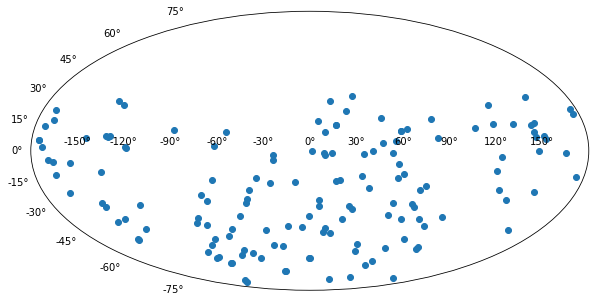

In [4]:

ra = coord.Angle(df['RAJ2000']*u.degree)
ra = ra.wrap_at(180*u.degree)
dec = coord.Angle(df['DEJ2000']*u.degree)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="mollweide")
ax.scatter(ra.radian, dec.radian)

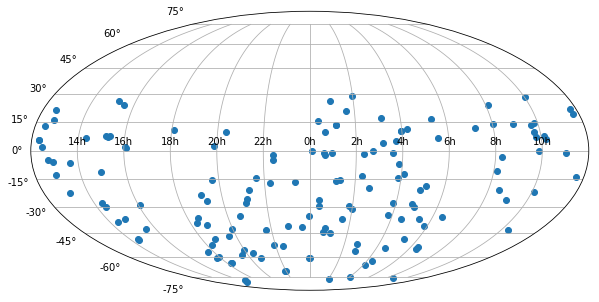

In [5]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="mollweide")
ax.scatter(ra.radian, dec.radian)
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax.grid(True)

$\textbf{#Integrated flux  at 151 MHz}$

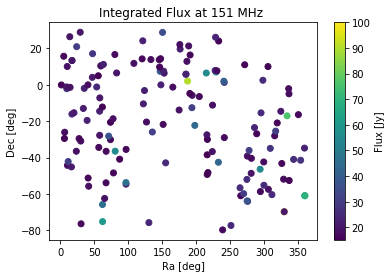

In [6]:
#Integrated flux 151 MHz
plt.title('Integrated Flux at 151 MHz ')
plt.scatter(df['RAJ2000'],df['DEJ2000'], c=df['int_flux_151'])
plt.xlabel('Ra [deg]')
plt.ylabel('Dec [deg]')
plt.colorbar(label ='Flux [Jy]')




$\textbf{Antenna Layout in ENU System}$

number of Antennas 19


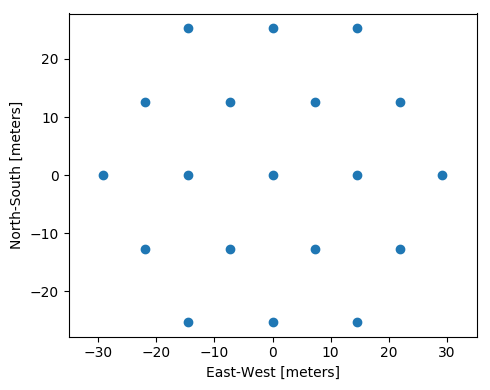

In [5]:
import antpos

antposs = antpos.hex_array(3,split_core= False, outriggers=0)

hera_hex_pos = np.array([list(pos) for pos in antposs.values()])

print 'number of Antennas', len(hera_hex_pos[:,0])

plt.figure(figsize=(5,4), dpi=100)
plt.scatter(hera_hex_pos[:,0],hera_hex_pos[:,1])
plt.xlabel("East-West [meters]")
plt.ylabel("North-South [meters]")
plt.axis('equal')
plt.tight_layout()

In [18]:
hera_hex_pos[0]

array([-29.2       ,  50.57588358,   0.        ])

$\textbf{Transform from ENU to XYZ}$


For a detailed discussion refer to lecture https://web.njit.edu/~gary/728/Lecture6.html


 \begin{gather}
 \begin{bmatrix} X  \\ Y \\ Z \end{bmatrix}
 =
  \begin{bmatrix}
   0 & -\sin(lat) &\cos(lat) \\
  1 & 0 & 0 \\
  0 & \cos(lat) & \sin(lat)
  \end{bmatrix} 
  \begin{bmatrix} E  \\ N \\ U \end{bmatrix}
\end{gather}


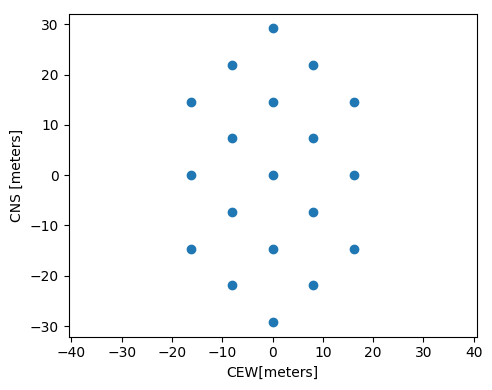

In [6]:
#E-N-U to XYZ Coordinates
#https://web.njit.edu/~gary/728/Lecture6.html

def XYZ_trans_mat(ENU_vec,lat):
    " This matrix transform antenna position from ENU to XYZ given the latitude"
    
    trans_mat = np.matrix([[0.0,-np.sin(lat),np.cos(lat)],[1.0,0.0,0.0],[0.0,np.cos(lat),np.sin(lat)]])
    XYZ =trans_mat.dot(ENU_vec)
    return np.array(XYZ)


#HERA latitude
lat = -30.722

XYZ_array = np.array([XYZ_trans_mat(hera_hex_pos[i],lat)[0] for i in range(len(hera_hex_pos))])

plt.figure(figsize=(5,4), dpi=100)
plt.scatter(XYZ_array[:,0],XYZ_array[:,1])
plt.xlabel("CEW[meters]")
plt.ylabel("CNS [meters]")
plt.axis('equal')
plt.tight_layout()





$\textbf{Computing Baseline Vectors}$


With 19 antennas there are 30 unique baselines.
1830 baselines


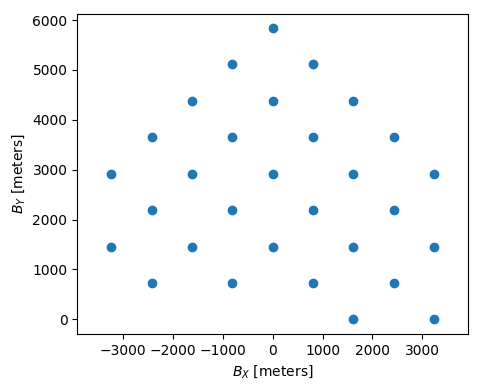

In [7]:
import get_ants_response

ants_indices = np.arange(len(XYZ_array))

ublDict = get_ants_response.InterferometricArray(XYZ_array,ants_indices).CalculateUBLs()[4] #computing Unique Baselines
print 61*60/2 ,"baselines"

B_xyz = np.array(ublDict.keys())

plt.figure(figsize=(5,4), dpi=100)
plt.scatter(B_xyz[:,0],B_xyz[:,1])
plt.xlabel(r"$B_X$ [meters]")
plt.ylabel(r"$B_Y$ [meters]")
plt.axis('equal')
plt.tight_layout()



In [9]:
np.save('ublDict_nants_19.npy',ublDict)

$\textbf{Transform from $\textit{B}_{\textrm{XYZ}}$ to $\textit{uvw}$ }$


For a detailed discussion refer to lecture https://web.njit.edu/~gary/728/Lecture6.html

Below is direction cosine matrix transformation of $\textit{B}_{\textrm{XYZ}}$ to the direction peperndicular to the phase center ($\textit{h}_0,\delta_0$), thus forming $\textit{uvw}$ 


 \begin{gather} 
 \begin{bmatrix} \textit{u}  \\ \textit{v}\\ \textit{w} \end{bmatrix}
 =\frac{1}{\lambda}
  \begin{bmatrix}
   \sin\textit{h}_0 & \cos\textit{h}_0 & 0 \\
  -\sin\delta_0\cos\textit{h}_0 & sin\delta_0\sin\textit{h}_0 & \cos\delta_0 \\
  \cos\delta_0\cos\textit{h}_0 &-\cos\delta_0\sin\textit{h}_0 & \sin\delta_0
  \end{bmatrix} 
  \begin{bmatrix} \textit{B}_{\textit{X}}  \\ \textit{B}_{\textit{Y}} \\ \textit{B}_{\textit{Z}}\end{bmatrix}
\end{gather}


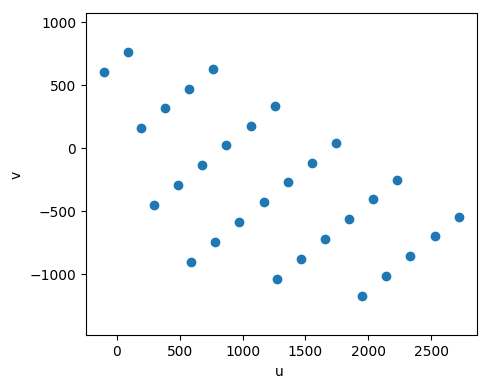

In [8]:
#Transform baseline to projected baseline

#phase center right above SKA karoor

#converting Long/Lat to RA/DEC https://lambda.gsfc.nasa.gov/toolbox/tb_coordconv.cfm

RA_0, Dec_0 = 21.41100,-30.72100 #degrees

def baseline_proj(bl_XYZ,RA_0,Dec_0):
    "Transform baseline to projected baseline given the phase center location in RA, DEC in degrees"
    trans_matt = np.matrix([[np.sin(np.deg2rad(RA_0)),np.cos(np.deg2rad(RA_0)),0.0],[-np.sin(np.deg2rad(Dec_0))*np.cos(np.deg2rad(RA_0)),np.sin(np.deg2rad(Dec_0))*np.sin(np.deg2rad(RA_0)),np.cos(np.deg2rad(Dec_0))],[np.cos(np.deg2rad(Dec_0))*np.cos(np.deg2rad(RA_0)),-np.cos(np.deg2rad(Dec_0))*np.sin(np.deg2rad(RA_0)),np.sin(np.deg2rad(Dec_0))]])
    bl_proj = trans_matt.dot(bl_XYZ)
    
    return np.array(bl_proj)


freq_mid =150e6 # Hz
wavelen = 3.0*10**8/freq_mid 
uvw = np.array([baseline_proj(B_xyz[i],RA_0,Dec_0)[0]*1.0/wavelen for i in range(len(B_xyz))])



plt.figure(figsize=(5,4), dpi=100)
plt.scatter(uvw[:,0],uvw[:,1])
plt.xlabel(r"u ")
plt.ylabel(r"v")
plt.axis('equal')
plt.tight_layout()



$\textbf{Section. 1.1 : Gaussian Primary Beam Model}$

The simplest primary beam model is Gaussain beam, it a good approximation of main lobe. It is a good enough to capture antenna-to-antenna variation due to pointing errors and spectral variation of ful l-width-half-maximum. A two dimensional Gaussian beam centered at origin (assuming the origin coincide with phase center) and   measure at angular co-ordinate $(\theta,\phi)$
\begin{equation}
        \textit{A}(\theta,\phi,\lambda)= \frac{1}{\sqrt{2\pi(\sigma(1+ \kappa))^2}}\textit{e}^{-\frac{(\theta + \varepsilon_{\theta})^2 + (\phi+ \varepsilon_{\phi})^2}{2(\sigma(1 +\kappa))^2}}
\end{equation}

where $\varepsilon_{\theta}$ and $\varepsilon_{\phi}$ are pointing errors, and $\kappa$ is a fractional error of the full-width-half-maximum. $\sigma$ is approximated from FWHM of ariy disk, 
\begin{equation}
        \sigma \approx 0.44\frac{\lambda}{\textit{D}}
\end{equation}

. Here $\textit{D}$ dish diameter.

reference

https://courses.lumenlearning.com/austincc-physics2/chapter/27-6-limits-of-resolution-the-rayleigh-criterion/


Text(0,0.5,'Normalized Power [Unitless]')

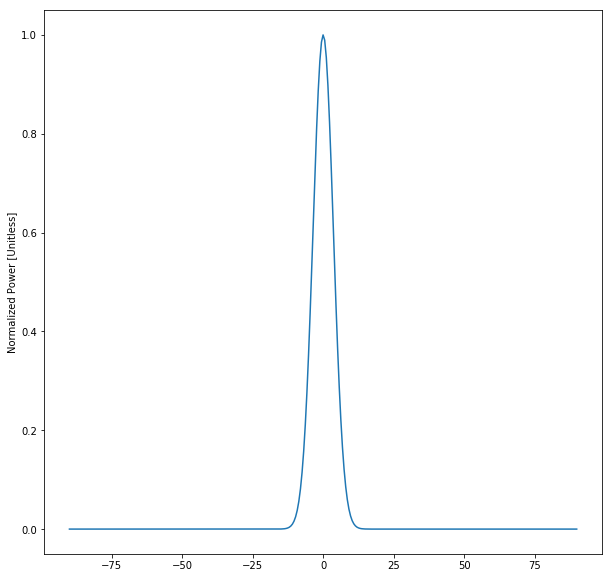

In [11]:
#1d Gaussain with and without beam size and point errors
import beam_simulator

freq_mid = 150e6
sigma_fwhm = beam_simulator.sigma_func(14.0,freq_mid)

theta, phi = np.arange(-np.pi/2.0,np.pi/2.0,0.01),np.arange(-np.pi,np.pi,0.1)

e_theta,e_phi = np.random.normal(0.0,np.deg2rad(0.2)), np.random.normal(0.0,np.deg2rad(0.2))  
kappa = np.random.normal(0.0,np.deg2rad(0.2)) # 
gaussian = [beam_simulator.gaussian_beam(theta[i],0.0,sigma_fwhm,0.0,0.0,0.0) for i in range(len(theta))]

plt.figure(figsize=(10,10))
plt.plot(np.rad2deg(theta),gaussian,label='Without Errors')
plt.ylabel('Normalized Power [Unitless]')


$\textbf{Visibility Simulation}$



In [3]:
lsts = np.linspace(np.deg2rad(30),12*np.deg2rad(30),10000)
freqs = np.arange(72.0,200.0,1.0)

#HERA Phase Center
RA_0,DEC_0 = 21.41100,-30.72100


ant1_pos = np.array([0.0,0.0,0.0]) # reference antenna position in ENU coordinate system
ant2_pos = np.array([14.6,0.0,0.0])

dish_diam = 14.0 # dish diameter
d_block = 0.5 #cage blockage
a_theta_ant1,a_phi_ant1,theta_c_ant1,phi_c_ant1,a_theta_ant2,a_phi_ant2,theta_c_ant2,phi_c_ant2 = 6.0,6.0,0.0,0.0,6.0,6.0,0.0,0.0
ant1_theta_error,ant1_phi_error, ant2_theta_error,ant2_phi_error,Ant1_beam_size_error,Ant2_beam_size_error = 0.0,0.0,0.0,0.0,0.0,0.0
vis_data_ad = vs.vis_sim_airydisk_beam_bl(ant1_pos,ant2_pos,dish_diam,d_block,RA_0,DEC_0,RA,DEC,flux_data,freqs,lsts,a_theta_ant1,a_phi_ant1,theta_c_ant1,phi_c_ant1,a_theta_ant2,a_phi_ant2,theta_c_ant2,phi_c_ant2)

In [4]:
#loading waterfall
lsts = np.linspace(np.deg2rad(30),12*np.deg2rad(30),10000)
freqs = np.arange(72.0,200.0,1.0)

vd_gaussian_beam = np.load('SB_Visibilitity_simulation_GB_GLEAM_BSRC_72_200MHz_LST.npy')
vd_airy_disk_beam = np.load('SB_Visibilitity_simulation_AD_GLEAM_BSRC_72_200MHz_LST.npy')

In [11]:
fftddata

(100, 128)

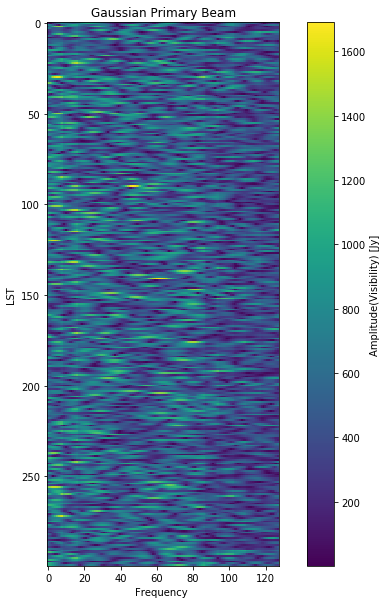

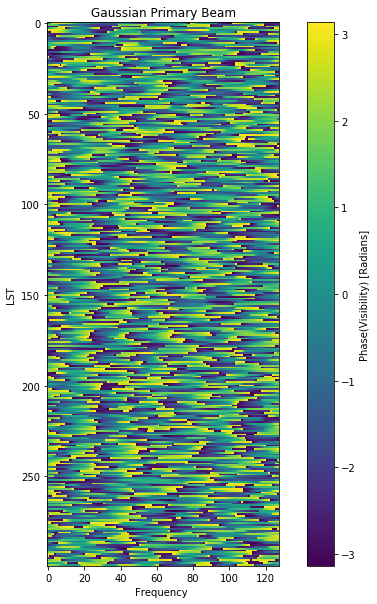

In [37]:
#extent =[freqs[0],freqs[-1],lsts[-1],lsts[0]]

plt.figure(figsize =(10,10))
plt.title("Gaussian Primary Beam")
plt.imshow(np.abs(vd_gaussian_beam[:300,:]))
plt.xlabel('Frequency ')
plt.ylabel('LST ')
plt.colorbar(label= r'Amplitude(Visibility) [Jy]')
plt.show()

plt.figure(figsize =(10,10))
plt.title("Gaussian Primary Beam")
plt.imshow(np.angle(vd_gaussian_beam[:300,:]))
plt.xlabel('Frequency ')
plt.ylabel('LST ')
plt.colorbar(label= r'Phase(Visibility) [Radians]')
plt.show()

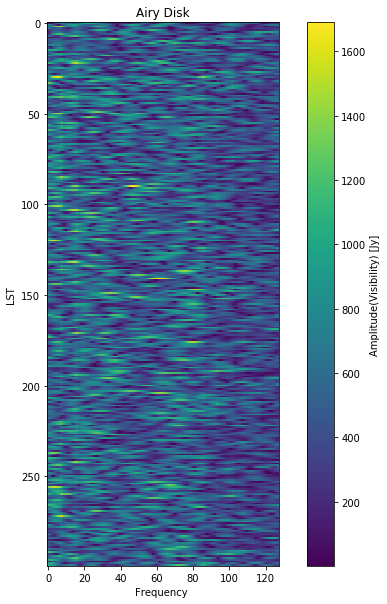

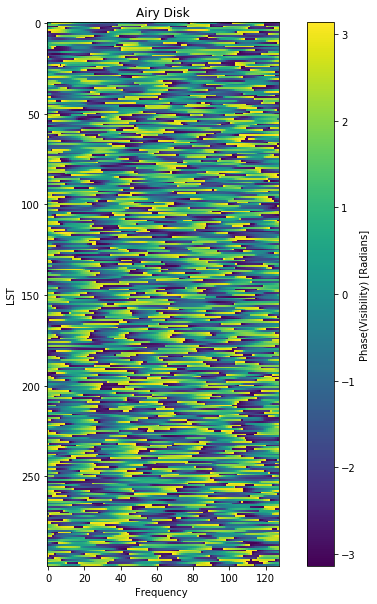

In [38]:
plt.figure(figsize =(10,10))
plt.title("Airy Disk")
plt.imshow(np.abs(vd_airy_disk_beam[:300,:]))
plt.xlabel('Frequency ')
plt.ylabel('LST ')
plt.colorbar(label= r'Amplitude(Visibility) [Jy]')
plt.show()

plt.figure(figsize =(10,10))
plt.title('Airy Disk')
plt.imshow(np.angle(vd_airy_disk_beam[:300,:]))
plt.xlabel('Frequency ')
plt.ylabel('LST ')
plt.colorbar(label= r'Phase(Visibility) [Radians]')
plt.show()

$\textbf{Non-redundant Visibility Simulation}$


5